In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

2021-11-23 02:30:59.301243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-23 02:30:59.301359: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from tensorflow.keras.utils import to_categorical

pixels = np.load('digits_pixels.npy')
n_cols = pixels.shape[1]
input_shape = (n_cols,)
numbers = to_categorical(np.load('digits_target.npy'))

from sklearn.model_selection import train_test_split

pixels_train, pixels_test, numbers_train, numbers_test = \
  train_test_split(pixels, numbers, test_size=0.3)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
  Dense(16, activation='relu', input_shape=input_shape),
  Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2021-11-23 02:31:02.148615: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-23 02:31:02.149048: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-23 02:31:02.149197: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-FC4EGDV): /proc/driver/nvidia/version does not exist
2021-11-23 02:31:02.149803: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Check to see if the untrained model works as expected
model.predict(pixels_train)

2021-11-23 02:31:02.324296: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


array([[3.81448045e-02, 2.17892625e-03, 6.48534358e-01, ...,
        5.50769083e-03, 1.01766586e-02, 9.63899132e-04],
       [1.11458026e-01, 3.43487784e-03, 7.76260972e-01, ...,
        7.59253232e-03, 1.28988009e-02, 6.86194748e-03],
       [6.85869949e-03, 6.05817465e-03, 1.58800334e-02, ...,
        7.64634786e-03, 1.75120726e-01, 9.69518498e-02],
       ...,
       [9.15175378e-01, 4.49312865e-05, 1.38670402e-02, ...,
        1.26379533e-07, 4.66470829e-06, 1.41345686e-06],
       [1.06048351e-02, 5.11729605e-02, 1.19536012e-01, ...,
        4.67895940e-02, 1.47218958e-01, 9.10539739e-03],
       [5.57154650e-04, 5.25486757e-05, 9.87335503e-01, ...,
        4.31936496e-06, 3.33294529e-03, 1.93794203e-05]], dtype=float32)

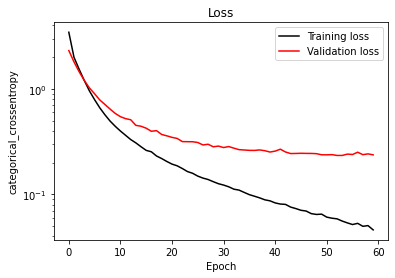

In [5]:
# Plot the training history
history = model.fit(pixels_train, numbers_train, epochs=60, validation_data=(pixels_test, numbers_test), verbose=False)

plt.plot(history.history['loss'], color='black', label='Training loss')
plt.plot(history.history['val_loss'], color='red', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('categorical_crossentropy')
plt.yscale('log')
plt.legend()
plt.show()

In [6]:
# What is the effect of adding more training data?
# Create an untrained model to use for experimentation

# Untrained model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
  Dense(16, activation='relu', input_shape=input_shape),
  Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save initial weights to allow for experimentation
initial_weights = model.get_weights()

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=1)

# Experiment metrics
train_accuracies = []
test_accuracies = []

# Define the number of training sizes
# to use in each round of experimentation
training_sizes = np.array([ 125,  502,  879, 1255])
for training_size in training_sizes:
  # Get a fraction of the training data
  pixels_train_frac = pixels_train[:training_size]
  numbers_train_frac = numbers_train[:training_size]
  
  # Reset the model to the initial weights
  # And train it on the new data fraction
  model.set_weights(initial_weights)
  model.fit(pixels_train_frac, numbers_train_frac, epochs=50, callbacks=[early_stop], verbose=False)

  # Record results
  train_accuracy = model.evaluate(pixels_train_frac, numbers_train_frac)[1]
  test_accuracy = model.evaluate(pixels_test, numbers_test)[1]
  
  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

17/17 [==============================] - 0s 1ms/step - loss: 0.1904 - accuracy: 0.9333


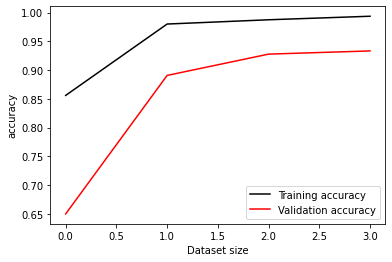

In [8]:
plt.plot(train_accuracies, color='black', label='Training accuracy')
plt.plot(test_accuracies, color='red', label='Validation accuracy')
plt.xlabel('Dataset size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [9]:
# We go back to the irrigation model

# Parcel irrigation data
# Three parcels, ¿do we have to irrigate or not?
irrigation = pd.read_csv('irrigation_machine.csv').drop('Unnamed: 0', axis=1)
parcel_columns = ['parcel_0', 'parcel_1', 'parcel_2']
parcels = irrigation[parcel_columns].values
sensors = irrigation.drop(parcel_columns, axis=1).values

from sklearn.model_selection import train_test_split
sensors_train, sensors_test, parcels_train, parcels_test = \
  train_test_split(sensors, parcels, test_size=0.3)

In [10]:
# We produce new models using a function
# This allow us to quickly experiment with different activation functions

def get_model(activation_function):
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Dropout

  nodes = 2**7
  rate = 0.8

  model = Sequential([
    Dense(nodes, activation=activation_function, input_shape=(20,)),
    Dropout(rate=rate),
    Dense(nodes, activation=activation_function),
    Dropout(rate=rate),
    Dense(nodes, activation=activation_function),
    Dropout(rate=rate),
    Dense(nodes, activation=activation_function),
    Dropout(rate=rate),
    Dense(nodes, activation=activation_function),
    Dropout(rate=rate),
    Dense(3, activation='sigmoid')
  ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  
  return model

# Example
model = get_model('relu')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               2688      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [11]:
# Activation functions to try
activations = ['relu', 'leaky_relu', 'sigmoid', 'tanh']

# Store experimentation results
activation_results = {}

for activation in activations:
  model = get_model(activation)
  history = model.fit(sensors_train, parcels_train, epochs=2**10, validation_data=(sensors_test, parcels_test), verbose=False)
  activation_results[activation] = history

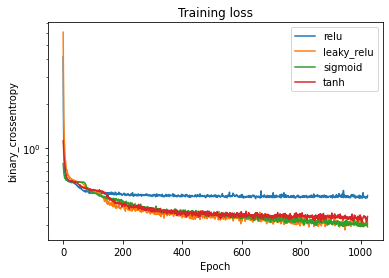

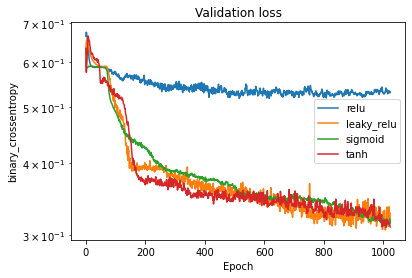

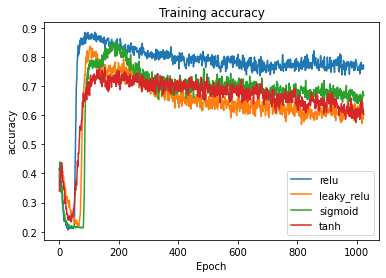

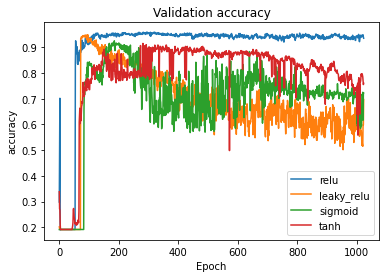

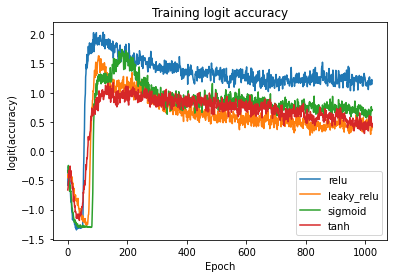

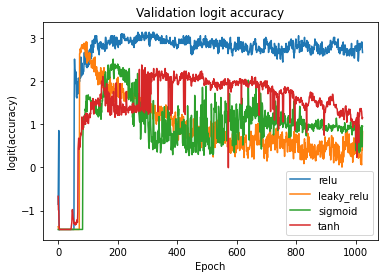

In [12]:
def metric_df(metric):
  return pd.DataFrame({activation: activation_results[activation].history[metric] for activation in activations})

loss = metric_df('loss')
val_loss = metric_df('val_loss')
accuracy = metric_df('accuracy')
val_accuracy = metric_df('val_accuracy')


loss.plot()
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("binary_crossentropy")
plt.yscale("log")
plt.show()

val_loss.plot()
plt.title("Validation loss")
plt.xlabel("Epoch")
plt.ylabel("binary_crossentropy")
plt.yscale("log")
plt.show()

accuracy.plot()
plt.title("Training accuracy")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.show()

val_accuracy.plot()
plt.title("Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.show()

sp.special.logit(accuracy).plot()
plt.title("Training logit accuracy")
plt.xlabel("Epoch")
plt.ylabel("logit(accuracy)")
plt.show()

sp.special.logit(val_accuracy).plot()
plt.title("Validation logit accuracy")
plt.xlabel("Epoch")
plt.ylabel("logit(accuracy)")
plt.show()

<AxesSubplot:>

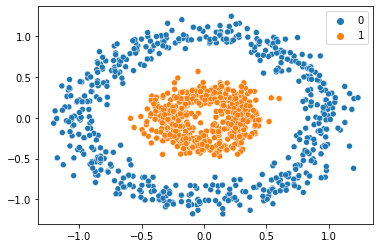

In [13]:
# Create a synthetic classification problem using scikit-learn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=1000, noise=.1, factor=.3)
n_cols = X.shape[1]
input_shape = (n_cols,)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.3, stratify=y)

n_training_samples = X_train.shape[0]

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)

In [14]:
# Exploring batch sizes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
  Dense(12, activation='relu', input_shape=input_shape),
  Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train using different batch sizes: 1, ..., n_training_samples
# Be amazed
batch_size = 1
model.fit(X_train, y_train, epochs=5, batch_size=batch_size)

testing_metrics = model.evaluate(X_test, y_test)

print(f"The accuracy when using a batch of size 1 is: {testing_metrics[1]}")

Epoch 1/5
300/300 [==============================] - 1s 1ms/step - loss: 0.6780 - accuracy: 0.4400
Epoch 2/5
300/300 [==============================] - 0s 1ms/step - loss: 0.6474 - accuracy: 0.5633
Epoch 3/5
300/300 [==============================] - 0s 1ms/step - loss: 0.6184 - accuracy: 0.6800
Epoch 4/5
300/300 [==============================] - 0s 1ms/step - loss: 0.5858 - accuracy: 0.8000
Epoch 5/5
22/22 [==============================] - 0s 1ms/step - loss: 0.5258 - accuracy: 0.9629
The accuracy when using a batch of size 1 is: 0.9628571271896362


In [15]:
# Revisit the MNIST dataset
from tensorflow.keras.utils import to_categorical

pixels = np.load('digits_pixels.npy')
n_cols = pixels.shape[1]
input_shape = (n_cols,)
numbers = to_categorical(np.load('digits_target.npy'))

from sklearn.model_selection import train_test_split

pixels_train, pixels_test, numbers_train, numbers_test = \
  train_test_split(pixels, numbers, test_size=0.3)

In [16]:
# Batch normalization in the MNIST digits dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

standard_model = Sequential([
  Dense(50, activation='relu', input_shape=input_shape, kernel_initializer='normal'),
  Dense(50, activation='relu', kernel_initializer='normal'),
  Dense(50, activation='relu', kernel_initializer='normal'),
  Dense(10, activation='softmax', kernel_initializer='normal')
])
standard_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# BatchNormalization --> kernel_initializer='normal'

batchnorm_model = Sequential([
  Dense(50, activation='relu', input_shape=input_shape, kernel_initializer='normal'),
  BatchNormalization(),
  Dense(50, activation='relu', kernel_initializer='normal'),
  BatchNormalization(),
  Dense(50, activation='relu', kernel_initializer='normal'),
  BatchNormalization(),
  Dense(10, activation='softmax', kernel_initializer='normal')
])
batchnorm_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

print(standard_model.summary())
print(batchnorm_model.summary())


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 50)                3250      
_________________________________________________________________
dense_37 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_38 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_39 (Dense)             (None, 10)                510       
Total params: 8,860
Trainable params: 8,860
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 50)                3250      
_________________________

In [17]:
history = {}
training_data = (pixels_train, numbers_train)
validation_data = (pixels_test, numbers_test)
epochs = 2**6
history['standard'] = standard_model.fit(*training_data, validation_data=validation_data, epochs=epochs, verbose=False)
history['batchnorm'] = batchnorm_model.fit(*training_data, validation_data=validation_data, epochs=epochs, verbose=False)

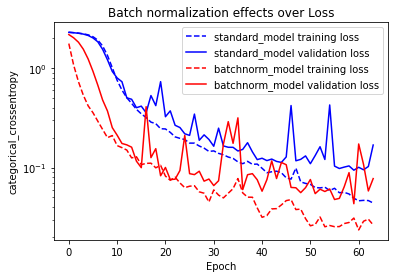

In [18]:
plt.plot(history['standard'].history['loss'], label='standard_model training loss', color='blue', linestyle='dashed')
plt.plot(history['standard'].history['val_loss'], label='standard_model validation loss', color='blue', linestyle='solid')
plt.plot(history['batchnorm'].history['loss'], label='batchnorm_model training loss', color='red', linestyle='dashed')
plt.plot(history['batchnorm'].history['val_loss'], label='batchnorm_model validation loss', color='red', linestyle='solid')
plt.title('Batch normalization effects over Loss')
plt.xlabel('Epoch')
plt.ylabel('categorical_crossentropy')
plt.yscale('log')
plt.legend()
plt.show()

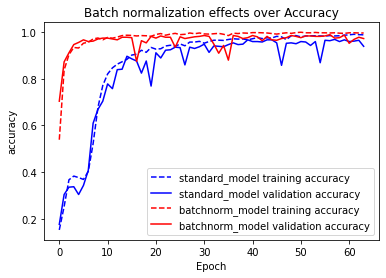

In [19]:
plt.plot(history['standard'].history['accuracy'], label='standard_model training accuracy', color='blue', linestyle='dashed')
plt.plot(history['standard'].history['val_accuracy'], label='standard_model validation accuracy', color='blue', linestyle='solid')
plt.plot(history['batchnorm'].history['accuracy'], label='batchnorm_model training accuracy', color='red', linestyle='dashed')
plt.plot(history['batchnorm'].history['val_accuracy'], label='batchnorm_model validation accuracy', color='red', linestyle='solid')
plt.title('Batch normalization effects over Accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

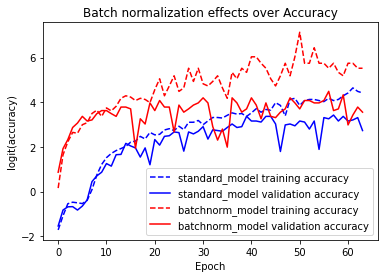

In [20]:
from scipy.special import logit

plt.plot(logit(history['standard'].history['accuracy']), label='standard_model training accuracy', color='blue', linestyle='dashed')
plt.plot(logit(history['standard'].history['val_accuracy']), label='standard_model validation accuracy', color='blue', linestyle='solid')
plt.plot(logit(history['batchnorm'].history['accuracy']), label='batchnorm_model training accuracy', color='red', linestyle='dashed')
plt.plot(logit(history['batchnorm'].history['val_accuracy']), label='batchnorm_model validation accuracy', color='red', linestyle='solid')
plt.title('Batch normalization effects over Accuracy')
plt.xlabel('Epoch')
plt.ylabel('logit(accuracy)')
plt.legend()
plt.show()

In [21]:
from sklearn.model_selection import train_test_split

breast_cancer_data = pd.read_csv('breast_cancer.csv').drop(['id', 'Unnamed: 32'], axis=1)

cell_characteristics = breast_cancer_data.drop('diagnosis', axis=1).values

breast_cancer_data['diagnosis'] = breast_cancer_data['diagnosis'].astype('category').cat.codes
diagnosis = breast_cancer_data['diagnosis'].values

cell_characteristics_train, cell_characteristics_test, diagnosis_train, diagnosis_test = \
  train_test_split(cell_characteristics, diagnosis, train_size=.3, stratify=diagnosis)

In [22]:
# Hyper-parameter tuning

# Model factory
def create_model(learning_rate, activation):
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense
  from tensorflow.keras.optimizers import Adam

  model = Sequential([
    Dense(128, activation=activation, input_shape=(30,)),
    Dense(256, activation=activation),
    Dense(1, activation='sigmoid')
  ])
  optimizer = Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  
  return model

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Use model factory to create a classification model
# that mimics the scikit-learn API!!!
model = KerasClassifier(build_fn=create_model, verbose=False)

# Now we can use scikit-learn to perform hyper-parameter optimization
from sklearn.model_selection import RandomizedSearchCV

params = {
  'activation': ['relu', 'tanh'],
  'batch_size': [2**5, 2**7, 2**8],
  'epochs': [50, 100, 200],
  'learning_rate': [.1, .01, .001]
}

search = RandomizedSearchCV(model, param_distributions=params, cv=3)

search.fit(cell_characteristics_train, diagnosis_train)

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5490d1dc70>,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'batch_size': [32, 128, 256],
                                        'epochs': [50, 100, 200],
                                        'learning_rate': [0.1, 0.01, 0.001]})

In [23]:
# Hyper-parameter exploration results
param_columns = ['param_' + name for name in params.keys()]
pd.DataFrame(search.cv_results_).sort_values('rank_test_score')[param_columns + ['mean_test_score']]

,param_activation,param_batch_size,param_epochs,param_learning_rate,mean_test_score
7,relu,32,200,0.001,0.953216
0,tanh,256,100,0.001,0.947160
1,relu,256,100,0.01,0.947160
6,relu,32,100,0.01,0.941416
5,tanh,32,100,0.001,0.911759
9,tanh,256,200,0.01,0.905806
4,tanh,128,200,0.01,0.893693
2,tanh,256,100,0.01,0.829678
8,tanh,32,50,0.1,0.524749
3,tanh,32,200,0.1,0.475251


In [24]:

search.score(cell_characteristics_test, diagnosis_test)

0.9147869944572449